This notebook provides the same code presented in the online tutorial available [here](https://matthewgilbert.github.io/blotter/tutorial) however we have ```sweep_time=None``` which allows closed PnL in JPY to accumulate, as seen below.

In [1]:
%pylab inline
import sys
sys.path.append("..")
from blotter import blotter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10
blt = blotter.Blotter(
           prices="../doc/data/prices",
           interest_rates="../doc/data/daily_interest_rates.csv",
           accrual_time=pd.Timedelta(16, unit="h"),
           eod_time=pd.Timedelta(16, unit="h"),
           sweep_time=None,
           base_ccy="USD",
           margin_charge=0.015
          )
blt.connect_market_data()

Populating the interactive namespace from numpy and matplotlib


In [2]:
blt.define_generic("AUDUSD", ccy="USD", margin=0, multiplier=1,
                       commission=2.5, isFX=True)
blt.define_generic("USDJPY", ccy="JPY", margin=0, multiplier=1,
                       commission=2.5, isFX=True)
blt.map_instrument(generic="AUDUSD", instrument="AUDUSD")
blt.map_instrument("USDJPY", "USDJPY")
blt.define_generic("CL", ccy="USD", margin=0.1, multiplier=1000,
                      commission=2.5, isFX=False)
blt.map_instrument("CL", "CLZ2008")

In [3]:
crude = pd.read_csv("../doc/data/prices/CLZ2008.csv", parse_dates=True, index_col=0)
aud = pd.read_csv("../doc/data/prices/AUDUSD.csv", parse_dates=True, index_col=0)
jpy = pd.read_csv("../doc/data/prices/USDJPY.csv", parse_dates=True, index_col=0)

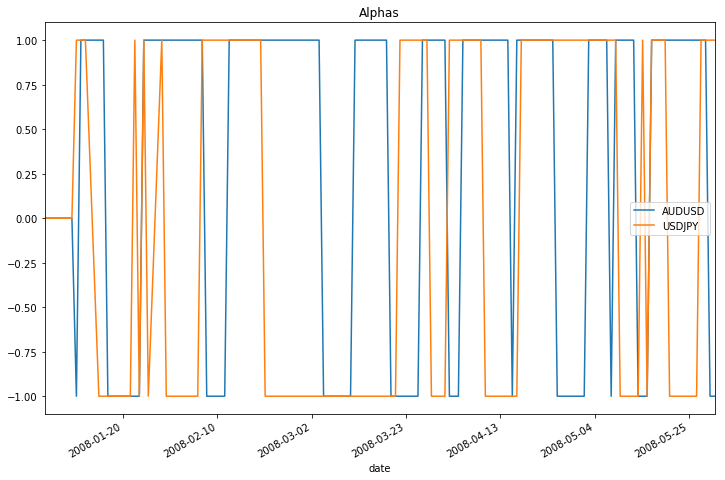

In [4]:
timestamps = pd.date_range("2008-01-02", "2008-05-27", freq="b")
timestamps = timestamps + pd.Timedelta("16h")
timestamps = (timestamps.intersection(crude.index)
              .intersection(aud.index).intersection(jpy.index))
ts = timestamps[0]
blt.trade(ts, "CLZ2008", 10, float(crude.loc[ts]))
aud_alpha = np.sign(np.log(aud / aud.shift(5))).fillna(value=0)
jpy_alpha = np.sign(np.log(jpy / jpy.shift(5))).fillna(value=0)


signal = pd.concat([aud_alpha, jpy_alpha], axis=1)
signal.columns = ["AUDUSD", "USDJPY"]
signal.plot(title="Alphas", figsize=(12, 8))

In [5]:
signal.tail()

,AUDUSD,USDJPY
date,,
2008-05-26 16:00:00,1.0,-1.0
2008-05-27 16:00:00,1.0,1.0
2008-05-28 16:00:00,1.0,1.0
2008-05-29 16:00:00,-1.0,1.0
2008-05-30 16:00:00,-1.0,1.0


In [6]:
def calc_trade(position, alpha):
    if position.empty:
        return alpha
    else:
        return alpha*1000000 - position

In [7]:
for ts in timestamps:
    pos = blt.get_instruments()
    pos = pos.drop("CLZ2008")
    trds = calc_trade(pos, signal.loc[ts,:])
    aud_qty = float(trds.loc["AUDUSD"])
    aud_price = float(aud.loc[ts])
    jpy_qty = float(trds.loc["USDJPY"])
    jpy_price = float(jpy.loc[ts])
    blt.trade(ts, "AUDUSD", aud_qty, aud_price)
    blt.trade(ts, "USDJPY", jpy_qty, jpy_price)

In [8]:
blt.get_instruments()

AUDUSD     1000000.0
CLZ2008         10.0
USDJPY     1000000.0
dtype: float64

In [9]:
ts = pd.Timestamp("2008-05-28T16:00:00")
blt.get_holdings_value(ts)

AUDUSD      962600.0
CLZ2008    1299600.0
USDJPY     1000000.0
dtype: float64

In [10]:
prices = {"AUDUSD": aud, "USDJPY": jpy, "CLZ2008": crude}
instrs = blt.get_instruments()
for instr, qty in instrs.iteritems():
    price = float(prices[instr].loc[ts])
    blt.trade(ts, instr, -qty, price)

In [11]:
blt.get_holdings_history()

{'JPY': {'USDJPY': 2008-01-09 16:00:00          1.0
  2008-01-10 16:00:00    1000000.0
  2008-01-14 16:00:00   -1000000.0
  2008-01-22 16:00:00    1000000.0
  2008-01-23 16:00:00   -1000000.0
                           ...    
  2008-05-15 16:00:00   -1000000.0
  2008-05-16 16:00:00    1000000.0
  2008-05-20 16:00:00   -1000000.0
  2008-05-27 16:00:00    1000000.0
  2008-05-28 16:00:00          0.0
  dtype: float64}, 'USD': {'AUDUSD': 2008-01-09 16:00:00         -1.0
  2008-01-10 16:00:00    1000000.0
  2008-01-16 16:00:00   -1000000.0
  2008-01-24 16:00:00    1000000.0
  2008-02-07 16:00:00   -1000000.0
                           ...    
  2008-05-07 16:00:00   -1000000.0
  2008-05-08 16:00:00    1000000.0
  2008-05-13 16:00:00   -1000000.0
  2008-05-16 16:00:00    1000000.0
  2008-05-28 16:00:00          0.0
  dtype: float64, 'CLZ2008': 2008-01-02 16:00:00    10000.0
  2008-05-28 16:00:00        0.0
  dtype: float64}}

In [12]:
ts = pd.Timestamp("2008-05-29T16:00:00")
blt.automatic_events(ts)

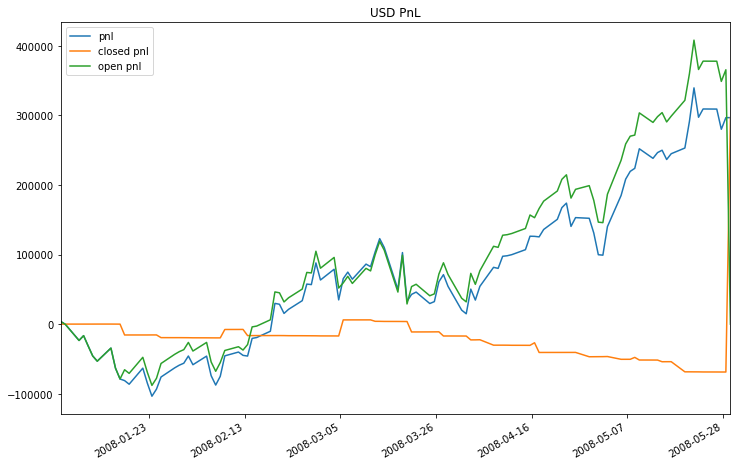

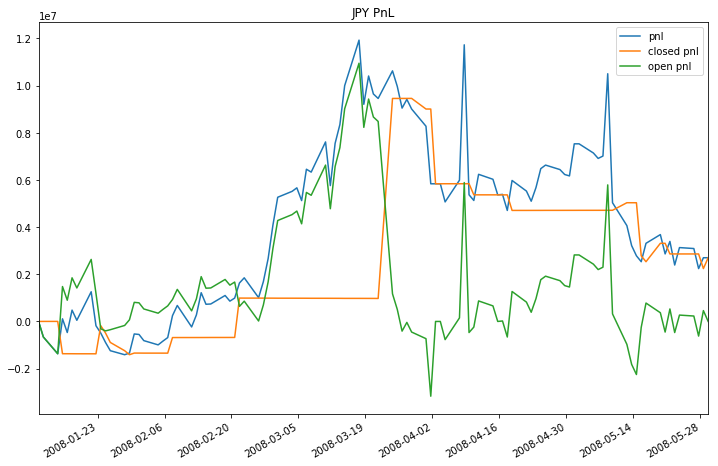

In [13]:
pnls = blt.get_pnl_history()
pnls
pnls["USD"].plot(title="USD PnL", figsize=(12, 8))
pnls["JPY"].plot(title="JPY PnL", figsize=(12, 8))

In [14]:
blt.event_log[-10:]

['TRADE|{"timestamp": "2008-05-28 16:00:00", "ccy": "USD", "commission": 2.5, "instrument": "AUDUSD", "price": 0.9626, "quantity": -1000000.0}',
 'CASH|{"timestamp": "2008-05-28 16:00:00", "ccy": "USD", "quantity": 962600.0}',
 'CASH|{"timestamp": "2008-05-28 16:00:00", "ccy": "AUD", "quantity": -1000000.0}',
 'TRADE|{"timestamp": "2008-05-28 16:00:00", "ccy": "USD", "commission": 2.5, "instrument": "CLZ2008", "price": 129.96, "quantity": -10000.0}',
 'TRADE|{"timestamp": "2008-05-28 16:00:00", "ccy": "JPY", "commission": 2.5, "instrument": "USDJPY", "price": 104.65, "quantity": -1000000.0}',
 'CASH|{"timestamp": "2008-05-28 16:00:00", "ccy": "JPY", "quantity": 104650000.0}',
 'CASH|{"timestamp": "2008-05-28 16:00:00", "ccy": "USD", "quantity": -1000000.0}',
 'INTEREST|{"timestamp": "2008-05-29 16:00:00", "ccy": "JPY", "quantity": -8.538355345205462}',
 'INTEREST|{"timestamp": "2008-05-29 16:00:00", "ccy": "USD", "quantity": -1.4318978007000005}',
 'PNL|{"timestamp": "2008-05-29 16:00: